In [1]:
%matplotlib inline
from matplotlib.pylab import plt

import pandas as pd
import numpy as np

# Let's look at some data with seasonality + trend

In [2]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

### How does it make sense to structure this data?

In [3]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
air_passengers = air_passengers.to_period()

In [5]:
air_passengers['1950-03-01':'1950-07-05']

,Passengers
Month,
1950-03,141
1950-04,135
1950-05,125
1950-06,149
1950-07,170


### How can we get a sense of this time series?

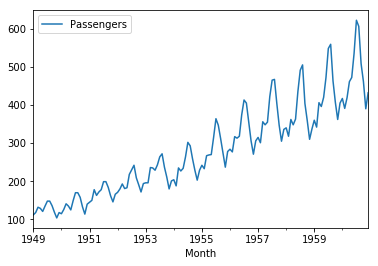

In [6]:
air_passengers.plot()

The first thing we look at for a time series when we want to use common analysis techniques: Is it stationary, implying constant mean, constant variance, and autocovariance does not depend on time?

### Have we got a time independent mean?

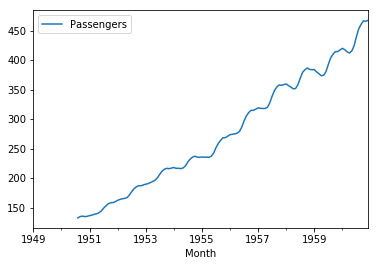

In [7]:
# first test, informally, plot the moving average
air_passengers.rolling(window = 20).mean().plot()

### Have we got a time independent variance?

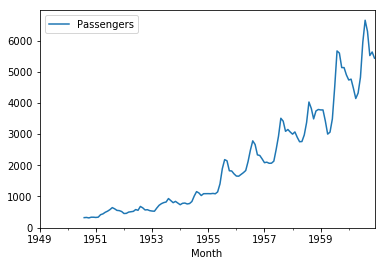

In [8]:
# Can you plot the variance?
air_passengers.rolling(window = 20).var().plot()

### How does sizing your window affect your results?

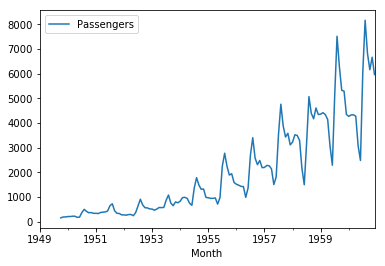

In [9]:
# Can you plot the variance?
air_passengers.rolling(window = 10).var().plot()

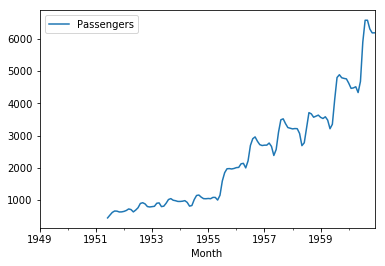

In [10]:
# Can you plot the variance?
air_passengers.rolling(window = 30).var().plot()

### How should you size your window?

# More formally testing for stationarity

In [11]:
# next more formally apply the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(air_passengers.Passengers, autolag = 'AIC')

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
dftest
# What do these numbers mean?

(0.81536887920605061,
 0.99188024343764103,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 996.69293083901903)

### Can we write a function to output these #s sensibly?
http://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html

In [13]:
from tabulate import tabulate

def table(dftest):
    return tabulate([["ADF Test Statistic", dftest[0]], ["p-value", dftest[1]], 
                     ["Number of Lags", dftest[2]], ["Number of Observations", dftest[3]],
                     ["MacKinnon's CV at 1%", dftest[4]['1%']], 
                     ["MacKinnon's CV at 5%", dftest[4]['5%']],
                     ["MacKinnon's CV at 10%", dftest[4]['10%']],
                     ["AIC", dftest[5]]], headers=["ADF Unit Root Test"])

In [14]:
print(table(dftest))

                          ADF Unit Root Test
----------------------  --------------------
ADF Test Statistic                  0.815369
p-value                             0.99188
Number of Lags                     13
Number of Observations            130
MacKinnon's CV at 1%               -3.48168
MacKinnon's CV at 5%               -2.88404
MacKinnon's CV at 10%              -2.57877
AIC                               996.693


### Are we stuck not doing any analysis now that our time series is not stationary?

Hint: no.
How can we make it stationary?
Why is it non-stationary (2 reasons)

It is non-stationary because it has an upward trend (increasing mean) and an increasing variance. Taking a logarithm transformation can stablize the variance. 

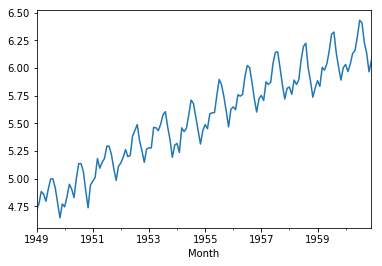

In [15]:
# First let's get rid of the 'trend' contribution to the time series not being stationary
# One method to get rid of a trend is to do a power or log transformation that punishes larger values
# more than smaller values
log_passengers = air_passengers.Passengers.apply(lambda x: np.log(x))
log_passengers.plot()

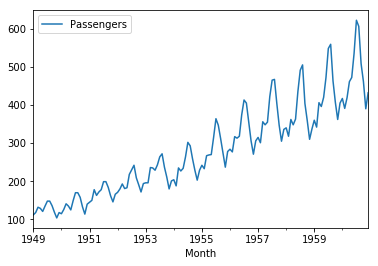

In [16]:
# This reduces the variance in variance as opposed to the original trend
air_passengers.plot()

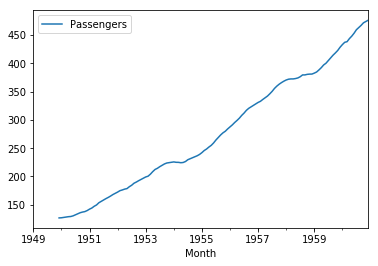

In [17]:
# However there is still a trend we need to remove
# Let's calculate a rolling mean
# Experiment with window size
air_passengers.rolling(window = 12).mean().plot()

This rolling window of size 12 smooths out the seasonality and captures the upward trend. 

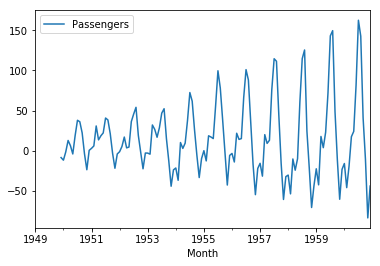

In [18]:
# What if we subtract this rolling mean from the original series?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
passengers_detrended.plot()

In [19]:
dftest = adfuller(passengers_detrended, autolag = 'AIC')
print(table(dftest))

ValueError: too many values to unpack (expected 2)

### Exercise: try detrending after taking the log. How does that look?

In [ ]:
log_rolling_mean = log_passengers.rolling(window = 12).mean()
log_passengers_detrended = log_passengers - log_rolling_mean
log_passengers_detrended.plot()

In [ ]:
dftest = adfuller(log_passengers_detrended, autolag = 'AIC')
print(table(dftest))

In [ ]:
# Now let's use a regression rather than a rolling mean to detrend
from statsmodels.regression.linear_model import OLS
model = OLS(air_passengers.Passengers.values, list(range(len(air_passengers.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(air_passengers.values)))), index = air_passengers.index)

passengers_detrended = air_passengers.Passengers - fit
passengers_detrended.plot()

In [ ]:
# When might a rolling average work better/worse than a regression?
# How might we be able to eliminate both trend and seasonality?
# One common technique is differencing, let's start with log_passengers
log_passengers_diff = log_passengers - log_passengers.shift()
log_passengers_diff.plot()

Let's again test for stationarity with a gut level check.

In [ ]:
dftest = adfuller(log_passengers_diff, autolag = 'AIC')
print(table(dftest))

In [ ]:
log_passengers = log_passengers.to_timestamp()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

log_passengers.interpolate(inplace = True)
decomposition = seasonal_decompose(log_passengers)

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
(seasonal+trend).plot()

In [ ]:
plt.subplot(411)
plt.plot(log_passengers, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()